In [1]:
# Import, configuration cell

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # simple matplotlib interface for data visualization

import os # to work with directories
import zipfile # to extract images from input .zip file
import shutil  # to copy data between folders

from tqdm import tqdm # loops progress bar 

import torch # main machine learning framework
#import imgaug.augmenters as iaa # image augmentation library
import torchvision # image loader, augmentation, neural networks architectures
from torchvision import transforms, models


# Configuration for the kernel
config = {
    "n_train_epoch": 65,
    "batch_size": 8,
    "scheduler_use": False,
    "n_augmentation_repeat": 8,
    "show_train_progress": True,
    "show_augmented_images": True
}

In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# Any results you write to the current directory are saved as output.

print('Contents of the input folder: \n', 
      os.listdir("../input/"))

# Extract all the contents of zip file in current directory
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
    zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction: \n', 
      os.listdir("/kaggle/working/"))

Contents of the input folder: 
 ['plates.zip', 'sample_submission.csv']
After zip extraction: 
 ['__notebook__.ipynb', '__MACOSX', 'plates']


In [3]:
data_root = '/kaggle/working/plates/'
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

# Creating 'cleaned' and 'dirty' folders inside the 'train' and 'val' directories
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

# Copy images from the 'train' folder to the new 'train' folder considering the labels
# Each sixth image goes to validation data
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(sorted(os.listdir(source_dir)))):
        dest_dir = os.path.join(train_dir if i%5!=0 else val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), 
                        os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 3423.12it/s]


In [4]:
!ls train/cleaned

0000.jpg  0002.jpg  0005.jpg  0007.jpg	0010.jpg  0012.jpg  0015.jpg  0017.jpg
0001.jpg  0003.jpg  0006.jpg  0008.jpg	0011.jpg  0013.jpg  0016.jpg  0018.jpg


In [5]:
# Train augmentation cell with imgaug library.
# Unfortunaly, this library doesn't updated on kaggle, so i couldn't use a lot of important functions.
# This cell isn't used, but just i just left it here.

# random_using(0.45, ...) applies the given augmenter in 45% of all cases.
random_using = lambda aug: iaa.Sometimes(0.45, aug)

class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential(
            [
                # Apply the following augmenters to most images
                random_using(iaa.CropAndPad(percent=(-0.1, 0.3))),
                iaa.Fliplr(0.5), # horizontally flip 50% of all images
                iaa.Flipud(0.2),  # vertically flip 20% of all images
                random_aug_use(iaa.Affine(
                    rotate=(-90, 90), # rotate by -90 to +45 degrees
                )),
                iaa.Add((30, 30)), # change brightness of images (by -30 to 30 of original value) 
                iaa.AddToHueAndSaturation((-15, 15))               
            ], random_order=True)
    
    def __call__(self, img):
        img = np.array(img)
        return np.ascontiguousarray(self.aug.augment_image(img))

In [6]:
train_transforms = transforms.Compose([
    #ImgAugTransform(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.35),
    transforms.RandomAffine(degrees=(-60, 60)),
    transforms.ColorJitter(brightness=(0.7, 1.35), 
                           contrast=(0.8, 1.4), 
                           saturation=(0.8, 1.2), 
                           hue=(-0.1, 0.1)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torch.utils.data.ConcatDataset([
     torchvision.datasets.ImageFolder(train_dir, train_transforms)
    for _ in range(config['n_augmentation_repeat'])
])
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)


batch_size = config['batch_size']
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [7]:
def show_input(input_tensor, title=''):
    """
    Function for showing images. 
        
    Keyword arguments:
        input_rensor -- one torch.Tensor object
        title -- plate type (cleaned or dirty) (default '')
    """
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

  0%|          | 0/32 [00:00<?, ?it/s]

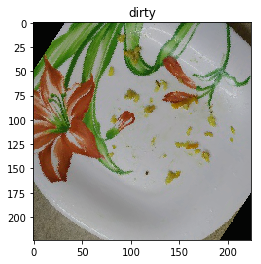

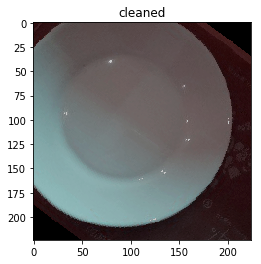

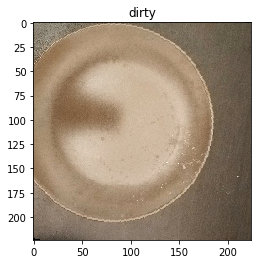

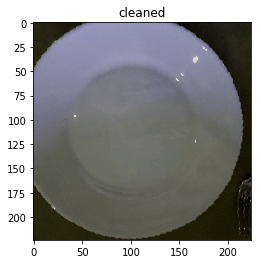

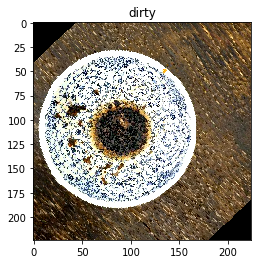

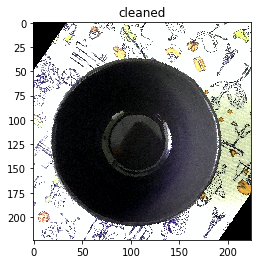

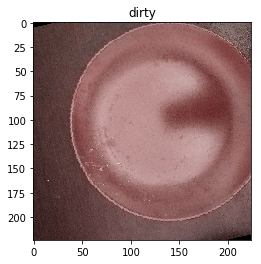

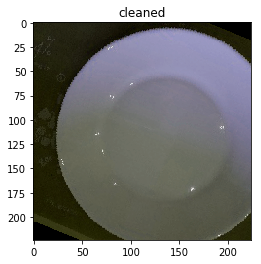

In [8]:
for X_batch, y_batch in tqdm(train_dataloader): 
    for x_item, y_item in zip(X_batch, y_batch):
        show_input(x_item, title=class_names[y_item])
    break

In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    """
    Model training function. In range of epochs number it passes 2 phases: training and validation.
    If the validation phase, we don't allow the network to change.
    
    Keyword arguments:
    """
    
    global config
    statistics = {
        'val_loss': [],
        'train_loss': [],
        'val_acc': [],
        'train_acc': []
    }
    
    for epoch in range(num_epochs):
        if config['show_train_progress']:
            print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                if config['scheduler_use']:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
                statistics['train_loss'].append(epoch_loss)
                statistics['train_acc'].append(epoch_acc.item())
            else:
                statistics['val_loss'].append(epoch_loss)
                statistics['val_acc'].append(epoch_acc.item())
    
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return (model, statistics)

In [10]:
model = models.mobilenet_v2(pretrained = True)

# Disable grad for all conv layers
#for param in model.parameters():
    #param.requires_grad = False

model.classifier[1] = torch.nn.Sequential(
    torch.nn.Linear(model.classifier[1].in_features, model.classifier[1].in_features),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),

    torch.nn.Linear(model.classifier[1].in_features, 2)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 14212972/14212972 [00:00<00:00, 18332058.27it/s]


In [11]:
model, stats = train_model(model, 
                           loss, 
                           optimizer, 
                           scheduler, 
                           num_epochs=config['n_train_epoch'])

Epoch 0/64:


100%|██████████| 32/32 [00:04<00:00,  6.44it/s]

train Loss: 0.6872 Acc: 0.5508



100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

val Loss: 0.6414 Acc: 0.8750
Epoch 1/64:



100%|██████████| 32/32 [00:04<00:00,  7.63it/s]

train Loss: 0.6396 Acc: 0.6680



100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

val Loss: 0.6270 Acc: 0.7500
Epoch 2/64:



100%|██████████| 32/32 [00:03<00:00, 18.70it/s]

train Loss: 0.5945 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

val Loss: 0.6212 Acc: 0.6250
Epoch 3/64:



100%|██████████| 32/32 [00:04<00:00,  7.68it/s]

train Loss: 0.5938 Acc: 0.7305



100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

val Loss: 0.6032 Acc: 0.7500
Epoch 4/64:



100%|██████████| 32/32 [00:04<00:00,  7.73it/s]

train Loss: 0.5346 Acc: 0.7930



100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

val Loss: 0.5456 Acc: 0.8750
Epoch 5/64:



100%|██████████| 32/32 [00:04<00:00,  7.46it/s]

train Loss: 0.5203 Acc: 0.8242



100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

val Loss: 0.5793 Acc: 0.7500
Epoch 6/64:



100%|██████████| 32/32 [00:04<00:00,  7.78it/s]

train Loss: 0.4732 Acc: 0.8633



100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

val Loss: 0.5064 Acc: 0.8750
Epoch 7/64:



100%|██████████| 32/32 [00:04<00:00,  7.36it/s]

train Loss: 0.4333 Acc: 0.8711



100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

val Loss: 0.4823 Acc: 0.7500
Epoch 8/64:



100%|██████████| 32/32 [00:04<00:00, 18.08it/s]

train Loss: 0.3975 Acc: 0.8906



100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

val Loss: 0.4629 Acc: 0.8750
Epoch 9/64:



100%|██████████| 32/32 [00:04<00:00, 17.52it/s]

train Loss: 0.3741 Acc: 0.8867



100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

val Loss: 0.4034 Acc: 0.8750
Epoch 10/64:



100%|██████████| 32/32 [00:04<00:00, 17.40it/s]

train Loss: 0.3609 Acc: 0.8828



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 0.3695 Acc: 0.8750
Epoch 11/64:



100%|██████████| 32/32 [00:04<00:00,  7.85it/s]

train Loss: 0.3139 Acc: 0.9219



100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

val Loss: 0.3205 Acc: 1.0000
Epoch 12/64:



100%|██████████| 32/32 [00:04<00:00,  7.59it/s]

train Loss: 0.2629 Acc: 0.9219



100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

val Loss: 0.3361 Acc: 0.8750
Epoch 13/64:



100%|██████████| 32/32 [00:04<00:00,  7.84it/s]

train Loss: 0.2670 Acc: 0.9180



100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

val Loss: 0.3174 Acc: 0.8750
Epoch 14/64:



100%|██████████| 32/32 [00:04<00:00,  7.57it/s]

train Loss: 0.2406 Acc: 0.9414



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 0.2764 Acc: 0.8750
Epoch 15/64:



100%|██████████| 32/32 [00:04<00:00,  7.84it/s]

train Loss: 0.2259 Acc: 0.9336



100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

val Loss: 0.2837 Acc: 0.8750
Epoch 16/64:



100%|██████████| 32/32 [00:04<00:00, 18.53it/s]

train Loss: 0.2002 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

val Loss: 0.3178 Acc: 0.8750
Epoch 17/64:



100%|██████████| 32/32 [00:04<00:00, 17.23it/s]

train Loss: 0.1995 Acc: 0.9531



100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

val Loss: 0.3159 Acc: 0.8750
Epoch 18/64:



100%|██████████| 32/32 [00:04<00:00,  7.67it/s]

train Loss: 0.1466 Acc: 0.9648



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.3093 Acc: 0.8750
Epoch 19/64:



100%|██████████| 32/32 [00:04<00:00,  7.47it/s]

train Loss: 0.1794 Acc: 0.9609



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.2494 Acc: 0.8750
Epoch 20/64:



100%|██████████| 32/32 [00:04<00:00,  7.20it/s]

train Loss: 0.1505 Acc: 0.9648



100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

val Loss: 0.2824 Acc: 0.8750
Epoch 21/64:



100%|██████████| 32/32 [00:04<00:00,  6.72it/s]

train Loss: 0.1352 Acc: 0.9570



100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

val Loss: 0.2382 Acc: 0.8750
Epoch 22/64:



100%|██████████| 32/32 [00:04<00:00,  7.52it/s]

train Loss: 0.1305 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

val Loss: 0.1930 Acc: 0.8750
Epoch 23/64:



100%|██████████| 32/32 [00:04<00:00,  7.49it/s]

train Loss: 0.1198 Acc: 0.9727



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.2826 Acc: 0.8750
Epoch 24/64:



100%|██████████| 32/32 [00:04<00:00,  7.28it/s]

train Loss: 0.1142 Acc: 0.9766



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 0.1876 Acc: 0.8750
Epoch 25/64:



100%|██████████| 32/32 [00:04<00:00,  7.71it/s]

train Loss: 0.1238 Acc: 0.9492



100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

val Loss: 0.1635 Acc: 0.8750
Epoch 26/64:



100%|██████████| 32/32 [00:04<00:00,  7.85it/s]

train Loss: 0.1114 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

val Loss: 0.2226 Acc: 0.8750
Epoch 27/64:



100%|██████████| 32/32 [00:04<00:00,  7.88it/s]

train Loss: 0.1405 Acc: 0.9492



100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

val Loss: 0.2321 Acc: 0.8750
Epoch 28/64:



100%|██████████| 32/32 [00:04<00:00, 19.47it/s]

train Loss: 0.0781 Acc: 0.9844



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.2185 Acc: 0.8750
Epoch 29/64:



100%|██████████| 32/32 [00:04<00:00,  7.78it/s]

train Loss: 0.1160 Acc: 0.9570



100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

val Loss: 0.1895 Acc: 0.8750
Epoch 30/64:



100%|██████████| 32/32 [00:04<00:00,  7.59it/s]

train Loss: 0.0865 Acc: 0.9844



100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

val Loss: 0.1679 Acc: 0.8750
Epoch 31/64:



100%|██████████| 32/32 [00:04<00:00, 18.63it/s]

train Loss: 0.0975 Acc: 0.9727



100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

val Loss: 0.1752 Acc: 0.8750
Epoch 32/64:



100%|██████████| 32/32 [00:04<00:00,  7.90it/s]

train Loss: 0.0874 Acc: 0.9766



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.1709 Acc: 0.8750
Epoch 33/64:



100%|██████████| 32/32 [00:04<00:00, 18.53it/s]

train Loss: 0.0902 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.1919 Acc: 0.8750
Epoch 34/64:



100%|██████████| 32/32 [00:04<00:00,  7.07it/s]

train Loss: 0.0639 Acc: 0.9805



100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

val Loss: 0.2022 Acc: 0.8750
Epoch 35/64:



100%|██████████| 32/32 [00:04<00:00,  7.35it/s]

train Loss: 0.1100 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

val Loss: 0.3045 Acc: 0.8750
Epoch 36/64:



100%|██████████| 32/32 [00:03<00:00, 19.85it/s]

train Loss: 0.0642 Acc: 0.9805



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.2136 Acc: 0.8750
Epoch 37/64:



100%|██████████| 32/32 [00:04<00:00, 19.78it/s]

train Loss: 0.1044 Acc: 0.9609



100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

val Loss: 0.1926 Acc: 0.8750
Epoch 38/64:



100%|██████████| 32/32 [00:04<00:00,  7.40it/s]

train Loss: 0.0609 Acc: 0.9805



100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

val Loss: 0.1814 Acc: 0.8750
Epoch 39/64:



100%|██████████| 32/32 [00:04<00:00,  7.24it/s]

train Loss: 0.0647 Acc: 0.9844



100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

val Loss: 0.1355 Acc: 0.8750
Epoch 40/64:



100%|██████████| 32/32 [00:04<00:00,  7.85it/s]

train Loss: 0.0788 Acc: 0.9766



100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

val Loss: 0.1976 Acc: 0.8750
Epoch 41/64:



100%|██████████| 32/32 [00:04<00:00,  7.81it/s]

train Loss: 0.0695 Acc: 0.9727



100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

val Loss: 0.1673 Acc: 0.8750
Epoch 42/64:



100%|██████████| 32/32 [00:04<00:00,  7.67it/s]

train Loss: 0.0724 Acc: 0.9727



100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

val Loss: 0.3190 Acc: 0.8750
Epoch 43/64:



100%|██████████| 32/32 [00:04<00:00,  7.92it/s]

train Loss: 0.0942 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

val Loss: 0.1896 Acc: 0.8750
Epoch 44/64:



100%|██████████| 32/32 [00:04<00:00,  7.59it/s]

train Loss: 0.0422 Acc: 0.9922



100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

val Loss: 0.3461 Acc: 0.8750
Epoch 45/64:



100%|██████████| 32/32 [00:04<00:00,  7.49it/s]

train Loss: 0.0408 Acc: 0.9922



100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

val Loss: 0.3386 Acc: 0.8750
Epoch 46/64:



100%|██████████| 32/32 [00:04<00:00,  6.70it/s]

train Loss: 0.0253 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

val Loss: 0.0903 Acc: 1.0000
Epoch 47/64:



100%|██████████| 32/32 [00:04<00:00,  7.04it/s]

train Loss: 0.0459 Acc: 0.9883



100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

val Loss: 0.1713 Acc: 0.8750
Epoch 48/64:



100%|██████████| 32/32 [00:03<00:00, 19.37it/s]

train Loss: 0.0371 Acc: 0.9922



100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

val Loss: 0.1645 Acc: 0.8750
Epoch 49/64:



100%|██████████| 32/32 [00:04<00:00,  7.71it/s]

train Loss: 0.0740 Acc: 0.9805



100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

val Loss: 0.1481 Acc: 0.8750
Epoch 50/64:



100%|██████████| 32/32 [00:04<00:00, 19.78it/s]

train Loss: 0.0350 Acc: 0.9922



100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

val Loss: 0.1413 Acc: 0.8750
Epoch 51/64:



100%|██████████| 32/32 [00:04<00:00,  7.39it/s]

train Loss: 0.0302 Acc: 0.9961



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.2818 Acc: 0.8750
Epoch 52/64:



100%|██████████| 32/32 [00:04<00:00,  7.31it/s]

train Loss: 0.0420 Acc: 0.9844



100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

val Loss: 0.3362 Acc: 0.8750
Epoch 53/64:



100%|██████████| 32/32 [00:04<00:00, 18.81it/s]

train Loss: 0.0356 Acc: 0.9961



100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

val Loss: 0.1637 Acc: 0.8750
Epoch 54/64:



100%|██████████| 32/32 [00:04<00:00,  7.85it/s]

train Loss: 0.0633 Acc: 0.9727



100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

val Loss: 0.3301 Acc: 0.8750
Epoch 55/64:



100%|██████████| 32/32 [00:04<00:00,  7.79it/s]

train Loss: 0.0578 Acc: 0.9805



100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

val Loss: 0.3464 Acc: 0.8750
Epoch 56/64:



100%|██████████| 32/32 [00:04<00:00,  7.55it/s]

train Loss: 0.0397 Acc: 0.9844



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.2380 Acc: 0.8750
Epoch 57/64:



100%|██████████| 32/32 [00:03<00:00, 19.95it/s]

train Loss: 0.0546 Acc: 0.9844



100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

val Loss: 0.2464 Acc: 0.8750
Epoch 58/64:



100%|██████████| 32/32 [00:04<00:00, 15.88it/s]

train Loss: 0.0643 Acc: 0.9727



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.1642 Acc: 0.8750
Epoch 59/64:



100%|██████████| 32/32 [00:04<00:00,  6.63it/s]

train Loss: 0.0171 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

val Loss: 0.2385 Acc: 0.8750
Epoch 60/64:



100%|██████████| 32/32 [00:04<00:00,  7.24it/s]

train Loss: 0.0455 Acc: 0.9883



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.1697 Acc: 0.8750
Epoch 61/64:



100%|██████████| 32/32 [00:04<00:00,  7.86it/s]

train Loss: 0.0318 Acc: 0.9922



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.2641 Acc: 0.8750
Epoch 62/64:



100%|██████████| 32/32 [00:04<00:00,  7.42it/s]

train Loss: 0.0606 Acc: 0.9883



100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

val Loss: 0.1327 Acc: 0.8750
Epoch 63/64:



100%|██████████| 32/32 [00:04<00:00, 19.48it/s]

train Loss: 0.0291 Acc: 0.9961



100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

val Loss: 0.1929 Acc: 0.8750
Epoch 64/64:



100%|██████████| 32/32 [00:04<00:00, 19.30it/s]

train Loss: 0.0322 Acc: 0.9961



100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

val Loss: 0.3416 Acc: 0.8750


In [12]:
# Saving the model
model_filename = 'model_state_dict.pt'
torch.save(model.state_dict(), model_filename)

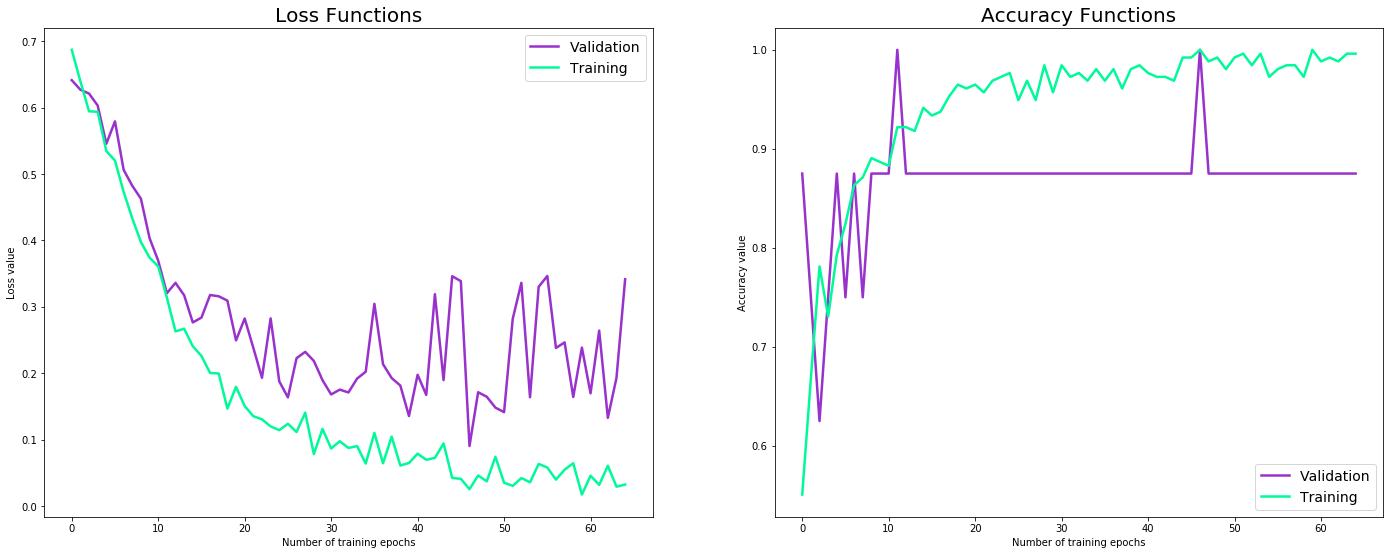

In [13]:
plt.figure(figsize=(24, 9))
function_names = ['Loss', 'Accuracy']
stats_names = iter(list(stats.keys()))
  
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    ax.plot(range(config['n_train_epoch']),
            stats[next(stats_names)], 
            label='Validation', 
            color='darkorchid', 
            lw=2.5)
    ax.plot(range(config['n_train_epoch']), 
            stats[next(stats_names)], 
            label='Training', 
            color='mediumspringgreen', 
            lw=2.5)
    ax.set_xlabel('Number of training epochs')
    ax.set_ylabel(function_names[i] + ' value')
    ax.set_title(function_names[i] + ' Functions', fontsize=20)
    ax.legend(fontsize=14)

##  Little comment

Beginning with 35 epoch we can see some overfitting traces. But as practice shows, by reducing the number of epochs to 20-35, we do not achieve an improvement in the model with a 100 percent probability. The model is learning unstable, and I got my best score at 65 epochs, when traces of overfitting appear in the interval of epochs from 18 to 25. But I am sure that by going through the options for training parameters, it would be possible to increase the score even more.

In [14]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), 
                os.path.join(test_dir, 'unknown'))

'test/unknown'

In [15]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [16]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [17]:
model.eval()

test_predictions = []

test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:04<00:00, 19.06it/s]


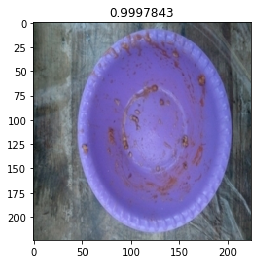

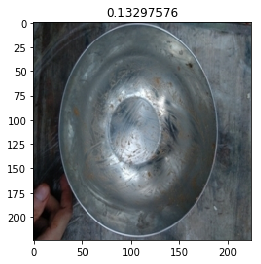

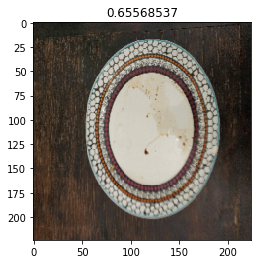

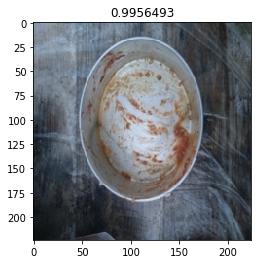

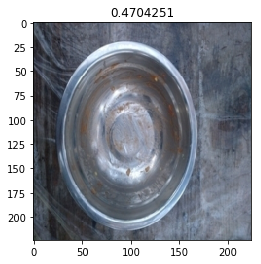

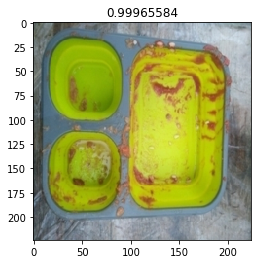

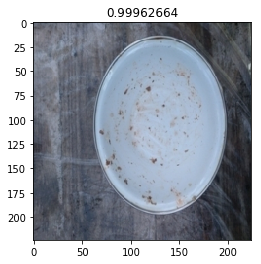

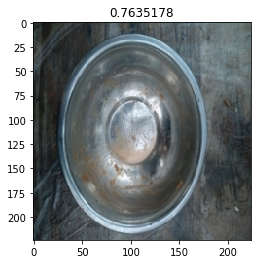

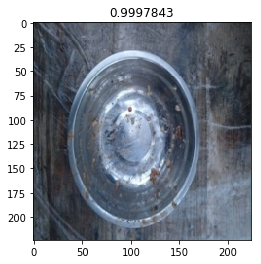

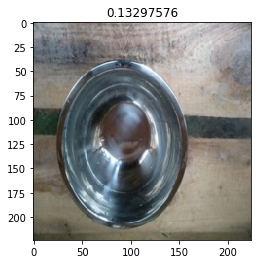

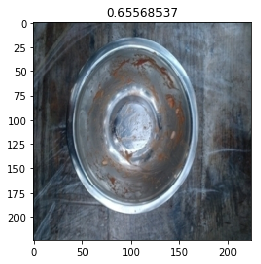

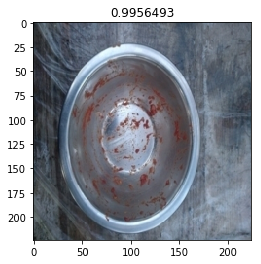

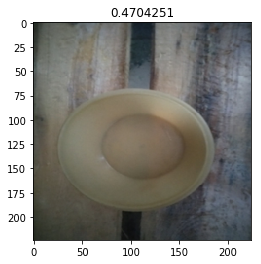

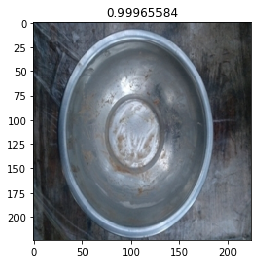

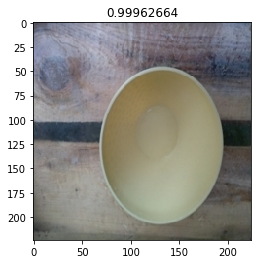

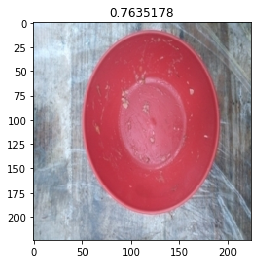

In [18]:
for i, (inputs, labels, paths) in enumerate(test_dataloader):
    for img, pred in zip(inputs, test_predictions):
        show_input(img, title=pred)
    if i == 1:
        break

In [19]:
# Creating and postprocessing data to csv file.
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=20)

,label
id,
0000,dirty
0001,cleaned
0002,dirty
0003,dirty
0004,cleaned
0005,dirty
0006,dirty
0007,dirty
0008,dirty


In [20]:
submission_df.to_csv("submission.csv")

In [21]:
!rm -rf plates train val test